In [ ]:
%tensorflow_version 2.x

In [ ]:
from os import listdir
from google.colab.patches import cv2_imshow
import h5py
import numpy as np
import cv2 as cv
import tensorflow as tf
import math
from matplotlib import pyplot as plt
from google.colab import drive
import pickle
import pandas as pd
import base64
print("Imported")

Imported


In [ ]:
# access google drive
drive.mount('/content/drive')

Mounted at /content/drive


Settings

In [ ]:
# SRCNN will scale image up by factor
scale = 4

# subimages
input_size = 33
label_size = 21
stride = 14
edge = int((input_size - label_size) / 2)

# file paths
training_images = "/content/drive/MyDrive/ISM/Final Product/SRCNN/data/train"
training_data = "/content/drive/MyDrive/ISM/Final Product/SRCNN/data/train.h5"
test_images = "/content/drive/MyDrive/ISM/Final Product/SRCNN/data/test"
weights_data = f"/content/drive/MyDrive/ISM/Final Product/SRCNN/checkpoints/weights_scale{scale}.ckpt"
save_model_path = f"/content/drive/MyDrive/ISM/Final Product/SRCNN/saved_models/{scale}x/"
test_results_path = f"/content/drive/MyDrive/ISM/Final Product/SRCNN/test_results/{scale}x"
training_results_path = f"/content/drive/MyDrive/ISM/Final Product/SRCNN/training_results/{scale}x.pickle"

# processes
run_train = False
run_test = False
run_graphs = True
run_save = False

Color Conversions

In [ ]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

print("defined")

defined


Prepare Training Data

In [ ]:
# generate training subimages and save them to HDF5 file
def prepare_training_data():
  # image settings

  input = []
  label = []

  filenames = listdir(training_images)
  for filename in filenames:
    image = cv.imread(training_images + '/' + filename)

    # change color space to ycrcb
    image = rgb2ycbcr(image)

    # only use luminance and normalize
    image = image[:, :, 0].astype(np.float) / 255.0

    # ensure image size is divisible by image scale factor for resizing
    size = image.shape
    size -= np.mod(size, scale)
    image_label = image[0:size[0], 0:size[1]]
    
    # create input image (degraded but same size)
    down_sized = cv.resize(image_label, (0,0), fx=1.0/scale, fy=1.0/scale, interpolation=cv.INTER_CUBIC)
    image_input = cv.resize(down_sized, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)

    # generate input and label subimages
    h = image_input.shape[0]
    w = image_input.shape[1]
    for r in range(0, h - input_size, stride):
      for c in range(0, w - input_size, stride):
        # use the stride to generate subimage
        subimage_input = image_input[r : r + input_size, c : c + input_size]
        subimage_label = image_label[r + edge : r + edge + label_size, c + edge : c + edge + label_size]

        # reshape to add third dimension for training
        subimage_input = subimage_input.reshape(input_size, input_size, 1)
        subimage_label = subimage_label.reshape(label_size, label_size, 1)

        # add to lists
        input.append(subimage_input)
        label.append(subimage_label)


  # shuffle the subimage data
  count = len(input)
  order = np.random.choice(count, count, replace=False)
  input = np.array([input[i] for i in order])
  label = np.array([label[i] for i in order])

  print(f"Prepared Training Data: {len(input)}")

  # save the training data to an HDF5 file
  with h5py.File(training_data, 'w') as td:
    td.create_dataset('input', data=input)
    td.create_dataset('label', data=label)

  print("saved")

print("defined")

defined


Build SRCNN

In [ ]:
def build_srcnn(learning_rate):
  # subimage size
  input_size = 33
  # filter counts
  n1, n2, n3 = 64, 32, 1
  # filter sizes
  f1, f2, f3 = 9, 5, 5

  srcnn = tf.keras.models.Sequential()
  # Patch Extraction: 64 9x9 filters, no padding, ReLU
  srcnn.add(tf.keras.layers.Conv2D(n1, (f1, f1), padding="VALID", activation='relu', input_shape=(input_size, input_size, 1)))
  # Non-linear Mapping: 32 5x5 filters, padding, ReLU
  srcnn.add(tf.keras.layers.Conv2D(n2, (f2, f2), padding="SAME", activation='relu'))
  # Reconstruction: 1 5x5 filter, no padding
  srcnn.add(tf.keras.layers.Conv2D(n3, (f3, f3), padding="VALID", activation='relu'))

  # PSNR custom metric function
  def psnr(y_true, y_pred):
    error = tf.keras.backend.square(y_pred - y_true)
    mse = np.mean(error.numpy()) 
    return 10 * math.log10(1.0 / mse)

  # Gradient Descent to minimize MSE with PSNR as metric
  srcnn.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[psnr],
      run_eagerly=True)

  return srcnn

print("defined")

defined


SRCNN Architecture

In [ ]:
def srcnn_architecture():
  build_srcnn(learning_rate=0).summary()

print("defined")

defined


Train SRCNN

In [ ]:
def train_model():
  # hyperparameters
  learning_rate = 0.0001
  epochs = 150
  batch_size = 128

  # load the training data
  input = []
  label = []
  with h5py.File(training_data, 'r') as td:
    input = np.array(td.get('input'))
    label = np.array(td.get('label'))

  # callback to save weights every epoch
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_data, save_weights_only=True, verbose=1)

  # train model
  srcnn = build_srcnn(learning_rate=learning_rate)
  history = srcnn.fit(x=input, y=label, epochs=epochs, validation_split=0.25, batch_size=batch_size, callbacks=[cp_callback])

  with open(training_results_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print("defined")

defined


Run Training

In [ ]:
if run_train:
  # print model architecture
  srcnn_architecture()

  # create training data
  prepare_training_data()

  # train and save weights
  train_model()

  print("Finished Training")

Preparing Test Data

In [ ]:
# prepare the images for testing
def prepare_test_images():
  images = []
  input_luminances = []

  filenames = listdir(test_images)
  for filename in filenames:
    image = cv.imread(test_images + '/' + filename)

    # ensure image size is divisible by image scale factor for resizing
    size = image.shape
    size -= np.mod(size, scale)
    image = image[0:size[0], 0:size[1]]

    # change color space to ycrcb
    image = rgb2ycbcr(image)
    images.append(image)

    # isolate luminance
    luminance = image[:, :, 0].astype(np.float) / 255.0
    
    # degrade luminance input
    luminance = cv.resize(luminance, (0,0), fx=1/scale, fy=1/scale, interpolation=cv.INTER_CUBIC)
    luminance = cv.resize(luminance, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    
    # reshape for model input
    luminance = luminance.reshape(luminance.shape[0], luminance.shape[1], 1)

    input_luminances.append(luminance)

  return filenames, images, input_luminances

print("defined")

defined


Test SRCNN

In [ ]:
def test_model():
  # get test data
  filenames, images, input_luminances = prepare_test_images()

  # create model
  model = build_srcnn(0)

  # load trained weights
  model.load_weights(weights_data)

  # define psnr
  def psnr(im1, im2):
    error = np.square(im1 - im2)
    mse = np.mean(error) 
    return 10 * math.log10(255.0**2 / mse)

  # shave borders for same dimensions
  def shave(image, border):
    return image[border:-border, border:-border]

  # print results
  for i in range(0, len(images)):
    label = shave(images[i][:, :, 0], edge)
    
    x = input_luminances[i]
    x = x.reshape(1, x.shape[0], x.shape[1], 1)
    output = model.predict(x)[0, :, :, 0] * 255

    bicubic = shave(input_luminances[i][:, :, 0] * 255, edge)

    print(f"Image {i}")
    print(f"Bicubic PSNR: {psnr(label, bicubic)}")
    print(f"SRCNN PSNR: {psnr(label, output)}")
    print("---------------------")

    output_image = np.zeros((output.shape[0], output.shape[1], 3))
    output_image[:, :, 0] = output
    output_image[:, :, 1:3] = shave(images[i][:, :, 1:3], edge)
    output_image = ycbcr2rgb(output_image)

    bicubic_image = np.zeros((bicubic.shape[0], bicubic.shape[1], 3))
    bicubic_image[:, :, 0] = bicubic
    bicubic_image[:, :, 1:3] = shave(images[i][:, :, 1:3], edge)
    bicubic_image = ycbcr2rgb(bicubic_image)

    cv.imwrite(f"{test_results_path}/srcnn/{filenames[i][0:filenames[i].index('.')]}.jpg", output_image)
    cv.imwrite(f"{test_results_path}/bicubic/{filenames[i][0:filenames[i].index('.')]}.jpg", bicubic_image)

print("defined")

defined


Run Tests

In [ ]:
if run_test:
  test_model()

Visualize Training

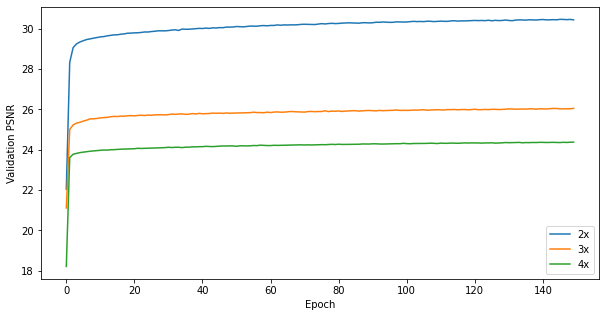

In [ ]:
if run_graphs:
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Validation PSNR")

  filenames = listdir('/content/drive/MyDrive/ISM/Final Product/SRCNN/training_results')
  for filename in filenames:
    history = pickle.load(open('/content/drive/MyDrive/ISM/Final Product/SRCNN/training_results/' + filename, "rb"))
    history = pd.DataFrame(history)

    epochs = list(range(0, 150))
    
    y = history['psnr']
    plt.plot(epochs, y, label=filename[0:filename.index('.')])

  plt.legend()

Save for TensorFlow Serving

In [ ]:
if run_save:
  model = build_srcnn(0)
  model.load_weights(weights_data)
    
  @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8),))
  def preprocessing(input_tensor):
    output_tensor = tf.cast(input_tensor, dtype=tf.float32)
    
    output_tensor = tf.image.rgb_to_yuv(output_tensor)

    output_tensor = output_tensor[:, :, 0]
    output_tensor = tf.divide(output_tensor, tf.constant(255.))

    output_tensor = tf.reshape(output_tensor, [tf.shape(output_tensor)[0], tf.shape(output_tensor)[1], 1])
    
    return output_tensor

  @tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.string),))
  def decode(image_bytes):
    input_tensor = tf.map_fn(
        lambda x: preprocessing(tf.io.decode_jpeg(contents=x, channels=3)),
        image_bytes,
        dtype=tf.float32,
    )
    return input_tensor

  @tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.string),))
  def serving(image_bytes):
    return {
      tf.saved_model.PREDICT_OUTPUTS: model(decode(image_bytes=image_bytes)),
    }

  tf.saved_model.save(
    model,
    export_dir=save_model_path,
    signatures={
      "serving_default": serving,
    },
  )

  print('saved')